In [69]:
# B1 Algorithm Outline
# Get raw CT Scans - read DICOM series
# Cast to float for consistency
# Edge preserving smoothing 
# Threshold for lungs ( - 1000 (air) to -500 (outline of healthy lung tissue) 
# Binary mask ( lungs & air (in and out) )
# Remove noise - specks and holes
# Outline and keep only the lungs
# Save and visualize

In [71]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os


In [23]:
from pathlib import Path

patient_path = Path("/Users/banazsinjary/Desktop/biomed-imaging/data/TCIA_COVID_CT/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/2.000000-ROUTINE CHEST NON-CON-97100")

files = list(patient_path.glob("*.dcm"))
print("Found:", len(files), "files")
for f in files[:5]:
    print(f.name)

Found: 255 files
1-013.dcm
1-007.dcm
1-239.dcm
1-211.dcm
1-205.dcm


sorted files ['1-001.dcm', '1-002.dcm', '1-003.dcm', '1-004.dcm', '1-005.dcm']
size (x,y,z) :  (512, 512, 255)
spacing (mm):  (0.703125, 0.703125, 1.25)
Array shape (z,y,x):  (255, 512, 512)


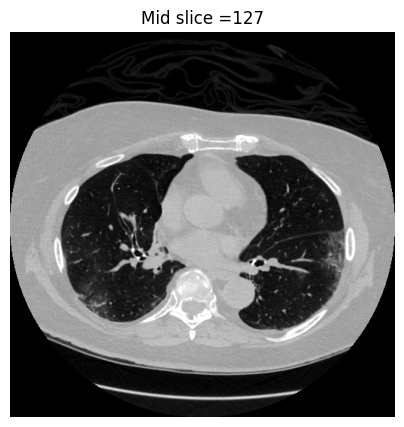

In [72]:
files_sorted = sorted(files, key= lambda p: p.name)
print ("sorted files", [p.name for p in files_sorted[:5]])

# read to a 3d image
reader = sitk.ImageSeriesReader()
reader.SetFileNames([str(f) for f in files_sorted])
img = reader.Execute()

# feed to array and check numbers for sizing and spacing relativity
ar = sitk.GetArrayFromImage(img)
print("size (x,y,z) : ", img.GetSize())
print("spacing (mm): ", img.GetSpacing())      
print("Array shape (z,y,x): ", ar.shape)

# get mid slice and visualize 
mid_slice = ar.shape[0]//2
plt.figure(figsize=(5,5))
plt.imshow(ar[mid_slice], cmap="gray", vmin=-1000, vmax=400)
plt.title(f"Mid slice ={mid_slice}")
plt.axis("off")
plt.show()

In [36]:
#casting form int to fload in order to avoid rounding errors for filtering

img_float = sitk.Cast(img, sitk.sitkFloat32)

stats = sitk.StatisticsImageFilter()
stats.Execute(img_float)
print(f"Min intensity: {stats.GetMinimum():.1f}, Max intensity: {stats.GetMaximum():.1f}")

Min intensity: -3024.0, Max intensity: 1857.0


In [40]:
# edge preserving smoothing using curvature anisotropic diffusion 
# time step, conductance - strength of diffusion process for edges 

c_a_d = sitk.CurvatureAnisotropicDiffusionImageFilter() 

c_a_d.SetNumberOfIterations(7)
c_a_d.SetTimeStep(0.0325)
c_a_d.SetConductanceParameter(3.0)

smooth = c_a_d.Execute(img_float) 


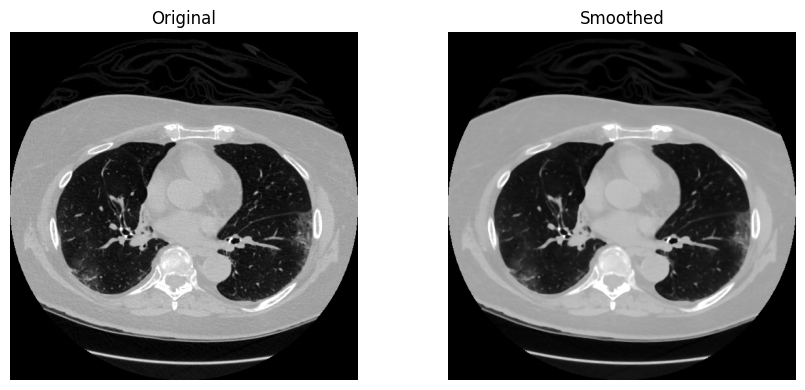

In [41]:
# view origional vs smoothed 
ar_orig   = sitk.GetArrayFromImage(img_float)
ar_smooth = sitk.GetArrayFromImage(smooth)

mid_slice = ar_orig.shape[0] // 2
plt.figure(figsize=(9,4))
plt.subplot(1,2,1); plt.imshow(ar_orig[mid_slice],   cmap="gray", vmin=-1000, vmax=400); plt.title("Original");  plt.axis("off")
plt.subplot(1,2,2); plt.imshow(ar_smooth[mid_slice], cmap="gray", vmin=-1000, vmax=400); plt.title("Smoothed"); plt.axis("off")
plt.tight_layout(); plt.show()

In [43]:
# binary threshold filter implementation

t_h_f = sitk.BinaryThresholdImageFilter()

t_h_f.SetLowerThreshold(-1000)
t_h_f.SetUpperThreshold(-500)
t_h_f.SetInsideValue(1)
t_h_f.SetOutsideValue(0)

mask = t_h_f.Execute(smooth) 

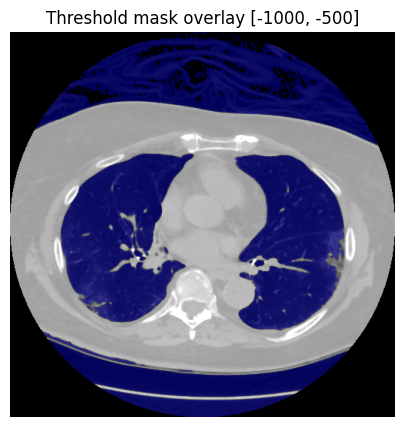

In [54]:
# visualize check 

ar_smooth = sitk.GetArrayFromImage(smooth)
mask_ar = sitk.GetArrayFromImage(mask)
mid_slice = ar_smooth.shape[0]//2

plt.figure(figsize=(5,5))
plt.imshow(ar_smooth[mid_slice], cmap="gray", vmin=-1000, vmax=400)
plt.imshow(np.ma.masked_where(mask_ar[mid_slice]==0, mask_ar[mid_slice]), cmap="bwr", alpha=0.35)
plt.title("Threshold mask overlay [-1000, -500]")
plt.axis("off")
plt.show()

In [66]:
# noise cleaning with morphology - opening filter

o_f = sitk.BinaryMorphologicalOpeningImageFilter()
o_f.SetKernelRadius(1)
o_f.SetForegroundValue(1)

mask_o_f = o_f.Execute(mask)

In [67]:
# fill holes in lung filter

f_f = sitk.BinaryFillholeImageFilter()
f_f.SetForegroundValue(1)

mask_f_f = f_f.Execute(mask_o_f)

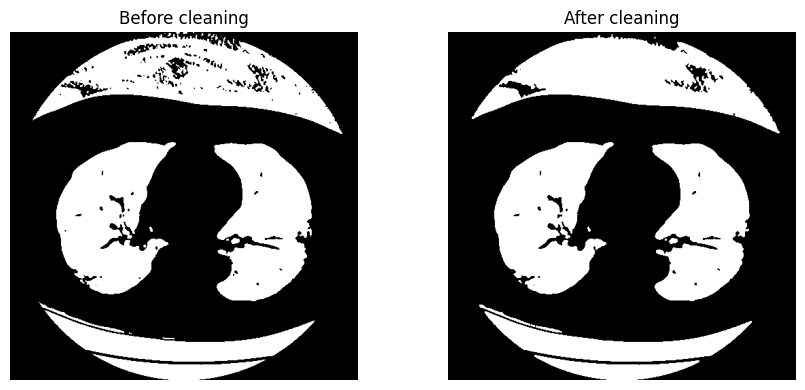

In [68]:
# visualize before and after noise cleaning 

noise_mask = sitk.GetArrayFromImage(mask)
clean_mask = sitk.GetArrayFromImage(mask_f_f)

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.imshow(noise_mask[mid_slice], cmap='gray'); plt.title("Before cleaning"); plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(clean_mask[mid_slice],  cmap='gray'); plt.title("After cleaning");  plt.axis("off")
plt.tight_layout(); plt.show()